joint_angles: [-41.3129447710396, -70.60293065439356, 93.29524578434406, -112.684918394183, -90.00021755105197, 48.68727278001238], selected_view: top
Joint coordinates for view top:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.86146310e-17 -1.51999995e-01]
 [ 8.35871622e-02 -1.13736264e-01 -5.52876830e-01]
 [ 2.99396724e-01 -4.07386303e-01 -4.00492847e-01]
 [ 2.17205688e-01 -4.67790216e-01 -4.00492847e-01]
 [ 2.77609587e-01 -5.49981236e-01 -4.00479674e-01]
 [ 2.77602255e-01 -5.49970627e-01 -3.00479680e-01]]
joint_angles: [-41.3129447710396, -70.60293065439356, 93.29524578434406, -112.684918394183, -90.00021755105197, 48.68727278001238], selected_view: right
Joint coordinates for view right:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.51999995e-01  3.37507789e-17]
 [-1.06018364e-01 -5.52876830e-01  9.31818560e-02]
 [-3.79741937e-01 -4.00492847e-01  3.33763480e-01]
 [-4.47079420e-01 -4.00492847e-01  2.57149756e-01]
 [-5.23693144e-01

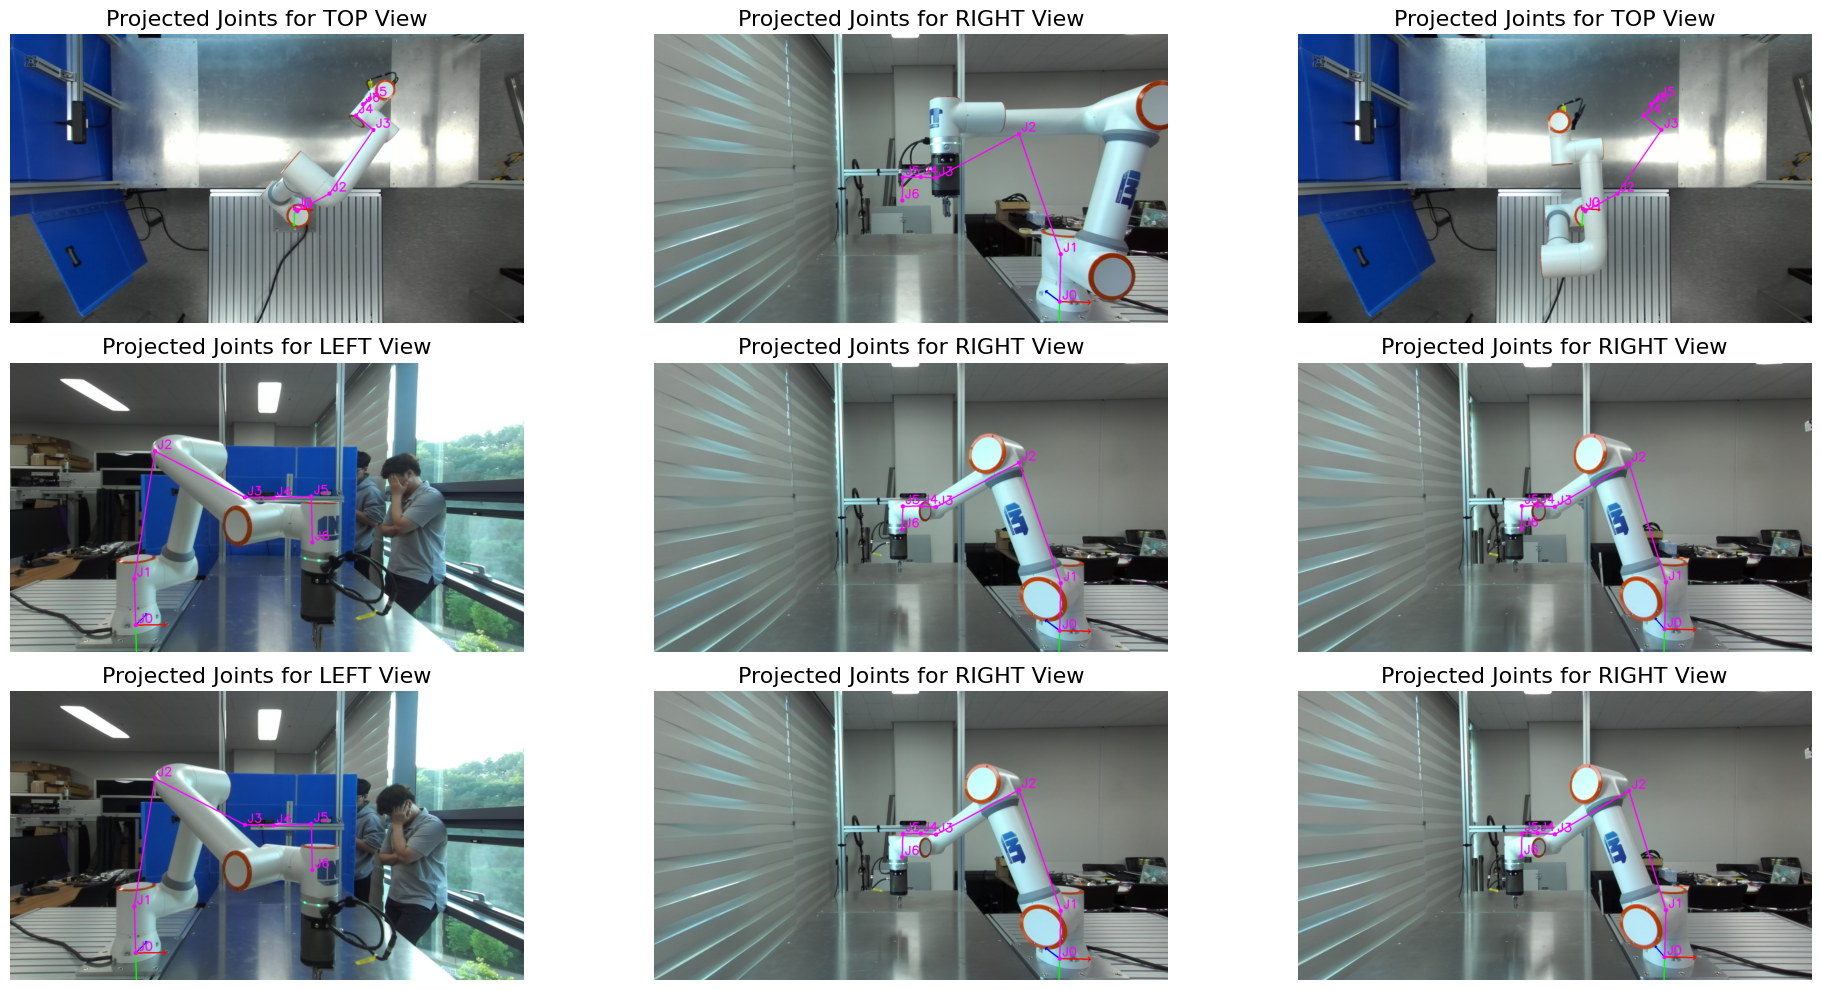

In [1]:
import os
import json
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ---------------------- ArUco 결과 및 데이터 경로 ----------------------
aruco_path = '../dataset/Fr5/Fr5_aruco_pose_summary.json'
with open(aruco_path, 'r') as f:
    aruco_results_all = json.load(f)


image_paths = [
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/top/zed_30779426_left_1748249285.123.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_3th_250526/right/zed_34850673_left_1748249051.395.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_3th_250526/top/zed_30779426_left_1748249051.401.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/left/zed_38007749_left_1748249285.548.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/right/zed_34850673_left_1748249285.554.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/right/zed_34850673_right_1748249285.554.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/left/zed_38007749_left_1748249285.964.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/right/zed_34850673_left_1748249285.973.jpg",
    "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/right/zed_34850673_right_1748249285.973.jpg"
]
joint_data_path = "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_6th_250526/joint/joint_30779426_1748249285.123.json"

# ---------------------- 조인트 데이터 로드 ----------------------
with open(joint_data_path, 'r') as f:
    joint_angles = json.load(f)

# ---------------------- DH 변환 행렬 계산 함수 ----------------------
def get_dh_matrix(a, d, alpha, theta):
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

# ---------------------- 조인트 각도를 카메라 좌표계 내 조인트 위치로 변환 ----------------------
def angle_to_joint_coordinate(joint_angles, selected_view):
    # FR5 DH parameters (degrees and meters)
    fr5_dh_parameters = [
        {'alpha': 90,  'a': 0,     'd': 0.152, 'theta': 0},
        {'alpha': 0,   'a': -0.425,'d': 0,     'theta': 0},
        {'alpha': 0,   'a': -0.395,'d': 0,     'theta': 0},
        {'alpha': 90,  'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': -90, 'a': 0,     'd': 0.102, 'theta': 0},
        {'alpha': 0,   'a': 0,     'd': 0.100, 'theta': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)

    # 카메라 뷰에 따른 베이스 좌표계 보정 회전 정의
    view_rotations = {
        'top': R.from_euler('zyx', [-85, 0, 180], degrees=True),
        'left': R.from_euler('zyx', [180, 0, 90], degrees=True),
        'right': R.from_euler('zyx', [0, 0, 90], degrees=True)
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = fr5_dh_parameters[i]
        theta = joint_angles[i] + params['theta']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

# ---------------------- 3D 조인트 좌표를 이미지 평면에 투영 ----------------------
def joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs):
    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        joint_coords, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

# ---------------------- 개별 뷰를 처리하고 플롯하는 함수 ----------------------
def plot_view(image_path, joint_angles, aruco_results_all):
    image_name = os.path.basename(image_path)
    parts = image_name.split('_')

    serial_str = parts[1]
    serial_to_view = {
        "38007749": "left",
        "34850673": "right",
        "30779426": "top"
    }
    selected_view = serial_to_view[serial_str]
    selected_cam = parts[2] + "cam"

    aruco_result = next(
        item for item in aruco_results_all 
        if item['view'] == selected_view and item['cam'] == selected_cam
    )

    camera_serials = {"top": 30779426, "right": 34850673, "left": 38007749}
    calib_dir = "../dataset/Fr5/Fr5_calib_cam_from_conf"
    serial = camera_serials[selected_view]
    calib_path = os.path.join(calib_dir, f"{selected_view}_{serial}_{selected_cam}_calib.json")

    with open(calib_path, 'r') as f:
        calib = json.load(f)

    camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)
    print(f"joint_angles: {joint_angles}, selected_view: {selected_view}")
    joint_coords = angle_to_joint_coordinate(joint_angles, selected_view)
    print(f"Joint coordinates for view {selected_view}:\n{joint_coords}")
    pixel_coords = joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs)

    aruco_axis_length = 0.1
    aruco_axis_points = np.array([
        [0, 0, 0],
        [aruco_axis_length, 0, 0],
        [0, aruco_axis_length, 0],
        [0, 0, aruco_axis_length]
    ], dtype=np.float32)

    Rvec = np.array([
        math.radians(aruco_result['rvec_x']),
        math.radians(aruco_result['rvec_y']),
        math.radians(aruco_result['rvec_z'])
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    projected_axes, _ = cv2.projectPoints(
        aruco_axis_points, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    projected_axes = projected_axes.reshape(-1, 2).astype(int)

    origin_aruco = tuple(projected_axes[0])
    x_end_aruco = tuple(projected_axes[1])
    y_end_aruco = tuple(projected_axes[2])
    z_end_aruco = tuple(projected_axes[3])

    image_with_axes = undistorted.copy()
    cv2.arrowedLine(image_with_axes, origin_aruco, x_end_aruco, (255, 0, 0), 3) # X - Red
    cv2.arrowedLine(image_with_axes, origin_aruco, y_end_aruco, (0, 255, 0), 3) # Y - Green
    cv2.arrowedLine(image_with_axes, origin_aruco, z_end_aruco, (0, 0, 255), 3) # Z - Blue

    font = cv2.FONT_HERSHEY_SIMPLEX
    for idx, (x, y) in enumerate(pixel_coords.astype(int)):
        text = f"J{idx}"
        cv2.circle(image_with_axes, (x, y), 8, (255, 0, 255), -1)
        cv2.putText(image_with_axes, text, (x + 10, y - 10), font, 1.5, (255, 0, 255), 3)
        
        if idx > 0:
            prev_x, prev_y = pixel_coords[idx-1].astype(int)
            cv2.line(image_with_axes, (prev_x, prev_y), (x, y), (255, 0, 255), 4)

    return image_with_axes, selected_view

# ---------------------- 메인 실행부 ----------------------
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    try:
        image_with_axes, selected_view = plot_view(image_path, joint_angles, aruco_results_all)
        ax = axes[i]
        ax.imshow(image_with_axes)
        ax.axis("off")
        ax.set_title(f"Projected Joints for {selected_view.upper()} View", fontsize=16)
    except FileNotFoundError as e:
        print(e)
        axes[i].set_title(f"Image not found for view {selected_view}", fontsize=12)
        axes[i].axis("off")

plt.tight_layout()
plt.show()